In [1]:
import pickle
from pandas import DataFrame
import pandas
from datetime import datetime, timedelta
from math import isnan
import random
from math import nan
from typing import Any
import matplotlib.pyplot as plt
import numpy as np

Entry = dict[str, Any]

pandas.options.mode.copy_on_write = True # Helps reduce redundant copying where possible
pandas.set_option("future.no_silent_downcasting", True) # Forward compatible warning

# Load the dataset
try:
    with open("data/bloomData.pkl", "rb") as dataPickle:
        fullData: DataFrame = pickle.load(dataPickle, fix_imports=True)
except:
    fullData = DataFrame()

Goals

* [] Temporal Analysis of Cheating Spread
* [] Predictive Modelling of Cheating Risk
* [] Game ownership analysis
* [] Playtime analysis

## Synthesizing information from data

First we filter out the data that isn't necessary in my usage.

In [2]:
# Replace EconomyBan to a boolean column
fullData:DataFrame = fullData.replace({"EconomyBan": {"banned": True, "none": False}}).infer_objects(copy=False)

data:DataFrame = fullData.loc[
    :,
    [
        "communityvisibilitystate",
        "personastate",
        "timecreated",
        "CommunityBanned",
        "NumberOfVACBans",
        "DaysSinceLastBan",
        "NumberOfGameBans",
        "EconomyBan",
        "friendsList",
        "ownedGames",
        "groups",
        "recentlyPlayed",
        "commentpermission",
        "loccountrycode",
        "avatar",
        "gameid"
    ],
]

### Determine privacy states

This may be useful for filtering purposes

In [3]:
from collections import defaultdict


friendsMapping = defaultdict[str, set[str]](lambda : set())

In [4]:
data["isProfilePublic"] = data["communityvisibilitystate"] > 0

# If game data is public, there will be a total_count field in recentlyPlayed dict
# Otherwise the key will not exist
data["isGameDataPublic"] = data["recentlyPlayed"].apply(lambda x: "total_count" in x)

In [5]:
from typing import cast
from pandas import Series


friendshipData = data["friendsList"]

for i, e in data.iterrows():
    i = cast(str, i)
    friends= e["friendsList"]
    if(friends is None):
        continue

    for friend in friends:
        otherID = friend["steamid"]
        friendsMapping[i].add(otherID)
        friendsMapping[otherID].add(i)

fmL  = {i : list(friendsMapping[cast(str,i)]) if i in friendsMapping else [] for i, _ in data.iterrows()}

data["augmentedFriends"] = Series(fmL)

In [6]:
def determineFriendListPrivacy(x: Entry):
    # We see the friendlist, it is public
    if len(x["friendsList"]) > 0:
        return True
    
    # We see that other friends are friends with this user, despite the list being empty
    # (Friendships are bidirectional on steam)
    if len(x["augmentedFriends"]) > 0:
        return False
    
    # Assume the default visibility is public
    # No discrepancies between actual friendlist and inferred friendslist
    return True


data["isFriendsListPublic"] = data.apply(determineFriendListPrivacy, axis=1)

### Main stuff

We can summarize all bans into a single "misdemeanor count" column. This is based on the assumption that all ban types on Steam contributes to whether a player is likely to cheat in the future. This is similar to how Valve determines the ["Trust Factor"](https://help.steampowered.com/en/faqs/view/00EF-D679-C76A-C185) of a player, which they use to protect high trust players from potentially low trust players, improving match quality.

In [7]:
data["MisdemenourCount"] = (
    data["NumberOfVACBans"]
    + data["NumberOfGameBans"]
    + data["CommunityBanned"].apply(lambda b: 1 if b else 0)
    + data["EconomyBan"].apply(lambda b: 1 if b else 0)
)

We then convert the relative timestamp of the players last ban time to an absolute timestamp. This allows us to avoid conversion through this process

In [8]:
currentTimestamp = datetime.now()
data["LastBanTime"] = data.apply(
    lambda x: (
        (currentTimestamp - timedelta(x["DaysSinceLastBan"])).timestamp()
        if (x["NumberOfVACBans"] + x["NumberOfGameBans"])
        else None
    ),  # type:ignore
    axis=1,
)

Unfortunately, we only have the timestamp for the latest ban given to a player. Due to privacy reasons we may not even have information of when a player created their Steam account, hindering our ability to synthesize ban times in the correct time range.

We want to provide a decent estimate of the exact ban instance of each cheater. We do have the total number of game bans, which includes both bans made by the Valve Anti-Cheat system (VAC), and manual bans given by other cheat detection methods such as third party cheat detectors or user review.

We perform the following steps to synthesize the timestamps for each cheating instances for a given player

* Iff we have information account creation time, that is set as the earliest possible ban time
* Iff the player's account doesn't have data on the account creation time, then we estimate the earliest possible ban time by assuming ban intervals are distributed equally
  * The earliest possible ban time is bounded to $[2023/09/12, \inf]$, the earliest known time VAC 2.0 is in effect, which is when VAC bans became permanent.
  * The creation time will also take into account known friendships, so that the earliest possible ban time is equal or earlier to the first known friendship

$$
\begin{aligned}
    \mathrm{earliestPossibleBanTime} = \mathrm{max}(&\mathrm{min}(\mathrm{lastBan} - \mathrm{timeSinseLastBan} * \mathrm{numBans}, \mathrm{earliestFriendshipTime}),\\
    & \mathrm{VACLaunchDate})
\end{aligned}
$$

Knowing both the account creation time, and the latest ban time, we can then generate ban times for a user based on a uniform distribution. We also include the user creation times and the latest ban times at the start and the end of the list for use later.

$$
\begin{aligned}
    \mathrm{times}_0 &= \mathrm{earliestPossibleBanTime} \\
    \mathrm{times}_i &= X \sim U_{[\mathrm{earliestPossibleBanTime}, \mathrm{lastBanTime}]} & \forall i \in \{ 1, \cdots, \mathrm{numBans}-1\} \\
    \mathrm{times}_{\mathrm{numBans}} &= \mathrm{lastBanTime}
\end{aligned}
$$



In [9]:
from math import inf


EARLIESTPOSSIBLEBAN = datetime(2003, 9, 12).timestamp()


def synthesizeEventTimes(x):
    numBans: int = x["NumberOfVACBans"] + x["NumberOfGameBans"]

    if numBans == 0:
        return []

    lastBan: float = x["LastBanTime"]
    timeCreated: float = x["timecreated"]
    earliestPossibleBanTime = timeCreated
    
    # timeCreated is not available
    #
    # Assumption made:
    #   The criminals activity is spaced based on a uniform  distribution centred around the last ban time
    if isnan(timeCreated):
        friendshipTimes = [f["friends_since"] for f in x["friendsList"] if f["friends_since"] != 0]

        earliestFriendshipTime = min(friendshipTimes) if len(friendshipTimes) > 0 else inf

        timeSinceLastBan = x["DaysSinceLastBan"]
        earliestPossibleBanTime = max(min(lastBan - timeSinceLastBan * numBans, earliestFriendshipTime), EARLIESTPOSSIBLEBAN)


    banRange = lastBan - earliestPossibleBanTime
    times = [lastBan - random.uniform(0, 1) * banRange for i in range(0, numBans)]

    times.sort()
    times.append(lastBan)

    return times

data["synthesizedTimes"] = data.apply(synthesizeEventTimes, axis=1)

One can notice that for cheaters, we actually generate one extra ban instance. This $0^{th}$ ban time will actually be used as one of three estimations for the account creation time of players who doesn't have any data on when their account was created

In [10]:
# First time is the creation time
# Any subsequent times are ban times
data["synthesizedTimes"] = data.apply(synthesizeEventTimes, axis=1)

# Try to get the existience 
def getLatestTime(x : Entry):
    latestBanTime = x["LastBanTime"]
    if not isnan(latestBanTime):
        return latestBanTime
    
    timecreated = x["timecreated"]

    if(not isnan(timecreated)):
        return timecreated
    
    return None


earliestTime = data.loc[:, ["timecreated"]].dropna()
latestTime = np.max(data.apply(getLatestTime, axis=1)) #type:ignore

validTimeMax = np.max(latestTime)
validTimeMin = np.min(earliestTime)
validTimeRange = validTimeMax - validTimeMin

def populateCreationTimes(x : Entry):
    timecreated = x["timecreated"]

    # We already have the information we need
    if(not isnan(timecreated)):
        return timecreated
    
    synthesizedTimes = x["synthesizedTimes"]

    friendshipTimes = [f["friends_since"] for f in x["friendsList"] if f["friends_since"] != 0]

    # Take the earliest known friendship if available
    earliestFriendshipTime = min(friendshipTimes) if len(friendshipTimes) > 0 else inf
    # And the earliest guess of ban time if available
    earliestBanTime = inf if len(synthesizedTimes) == 0 else synthesizedTimes[0]
    # And a guess based around a population based on a uniform distribution
    uniformDistGuess = validTimeMin + validTimeRange * random.random()

    # And take the minimum between all three
    timecreatedGuess = min([uniformDistGuess, earliestBanTime, earliestFriendshipTime])

    
    return timecreatedGuess

data["timecreated"] = data.apply(
    populateCreationTimes, # type:ignore
    axis=1,
)

data["EstimatedBanTimes"] = data.apply(
    lambda x: x["synthesizedTimes"][1:] if len(x["synthesizedTimes"]) > 0 else [],
    axis=1,
)

# Remove synthesizedTimes column
data.drop("synthesizedTimes", axis = 1, inplace=True)

## Temporal analysis of cheating spread

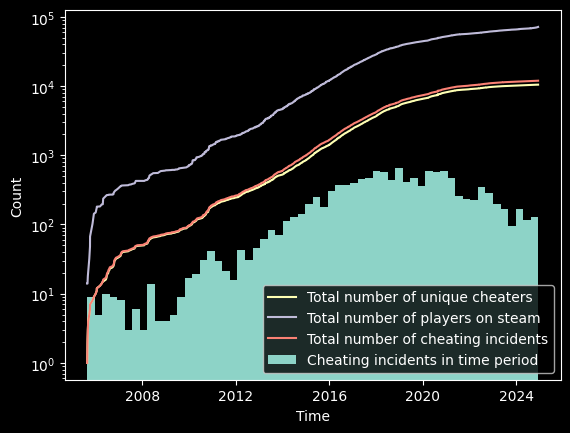

In [11]:
cheatingIncidents = []

uniqueCheaters = set()
numUniqueCheaters = []
numPlayers = []

count = 0

for i, e in data.sort_values("timecreated").iterrows(): 
    count+=1
    steamId = i
    banTimes  = e["EstimatedBanTimes"]

    for t in banTimes:
        cheatingIncidents.append((t, i))
        numPlayers.append(count)

    if(len(banTimes) == 0):
        continue

cheatingIncidents.sort(key = lambda x : x[0])

cheatingTimes = []
cheatingCount = [i+1 for i in range(len(cheatingIncidents))]
for t in cheatingIncidents:
    cheatingTimes.append(datetime.fromtimestamp(t[0]))
    uniqueCheaters.add(t[1])
    numUniqueCheaters.append(len(uniqueCheaters))

plt.hist(cheatingTimes, log=True, bins="auto")
plt.xlabel("Time")
plt.ylabel("Count")
plt.plot(cheatingTimes,numUniqueCheaters)
plt.plot(cheatingTimes,numPlayers)
plt.plot(cheatingTimes,cheatingCount)
plt.legend(["Total number of unique cheaters", "Total number of players on steam", "Total number of cheating incidents", "Cheating incidents in time period"])
plt.show()

By plotting the number of cheating incidents, the number of unique cheaters, and the total number of players on Steam. We can observe that as time passes, the number of users increases significantly. The number of unique cheaters increase in a significantly lower rate.

The total number of cheating incidents grows in the same fashion as the number of unique cheaters. Suggesting the most caught cheaters never cheat again (or at least get caught doing so), or they abandon their Steam account.

We can approximate the amount of cheaters that remain active on Steam using the same account by determining whether they have any activity on Steam post ban.

We are able to assert that a player is still active after a ban if any one of the following points are true
* Player status is not offline or invisible
* Player has more than one bans
  * This implies that even after the first ban, the user remained active enough to obtain another ban
* Player is found to be actively playing a game, or participating in a game server tracked by steam
* Player has recorded playtime in the two weeks prior to data collection

There are some deficiencies with this method, such as the fact that we do not have complete data of a particular user due to their chosen privacy settings, which hides information that is considered private to external users. In these cases, we assume the account is abandoned if none of the above points hold true.

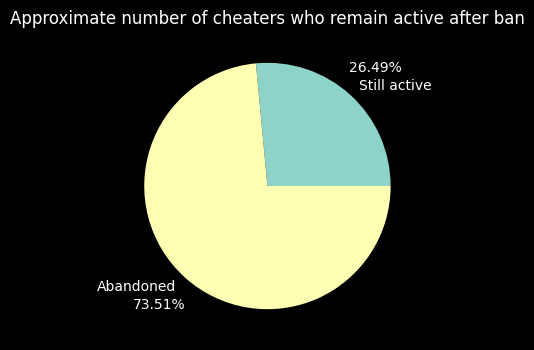

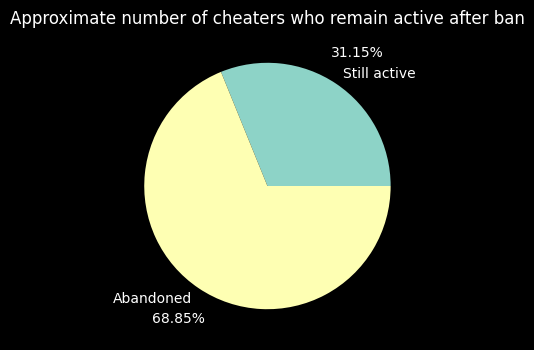

In [12]:
from pandas import isnull


cheaters = data.loc[(data["NumberOfVACBans"] + data["NumberOfGameBans"]) > 0, :]
innocents = data.loc[(data["NumberOfVACBans"] + data["NumberOfGameBans"]) == 0, :]


def isActive(x: Entry):
    if(x["personastate"] > 0):
        return True

    if x["NumberOfVACBans"] + x["NumberOfGameBans"] > 1:
        return True

    if not pandas.isnull(x["gameid"]) :
        return True

    recentlyPlayed: dict[str, Any] = x["recentlyPlayed"]

    activity =  recentlyPlayed.get("total_count", 0) > 0

    
    return activity


numberOfCheaters = len(cheaters)
numberOfInnocents = len(data) - numberOfCheaters

activeCheaters= cheaters.apply(isActive, axis=1)
activeInnocents = innocents.apply(isActive, axis=1)

numberOfActiveCheaters : int = activeCheaters.values.sum() # type:ignore
numberOfInactiveCheaters : int = numberOfCheaters - numberOfActiveCheaters

numberOfActiveInnocents = activeInnocents.values.sum() #type:ignore
numberOfInactiveInnocents = numberOfInnocents - numberOfActiveInnocents

plt.figure(figsize=(5,4))
plt.pie([numberOfActiveCheaters, numberOfInactiveCheaters], labels=["Still active", "Abandoned"], autopct="%.2f%%", pctdistance=1.3)
plt.title("Approximate number of cheaters who remain active after ban")
plt.show()

plt.figure(figsize=(5,4))
plt.pie([numberOfActiveInnocents, numberOfInactiveInnocents], labels=["Still active", "Abandoned"], autopct="%.2f%%", pctdistance=1.3)
plt.title("Approximate number of cheaters who remain active after ban")
plt.show()

## Playtime analysis

We also attempted to analyze the playtime of cheaters, to determine whether a cheater's playing habits differ significantly from a non-cheater. 

In order to do

73


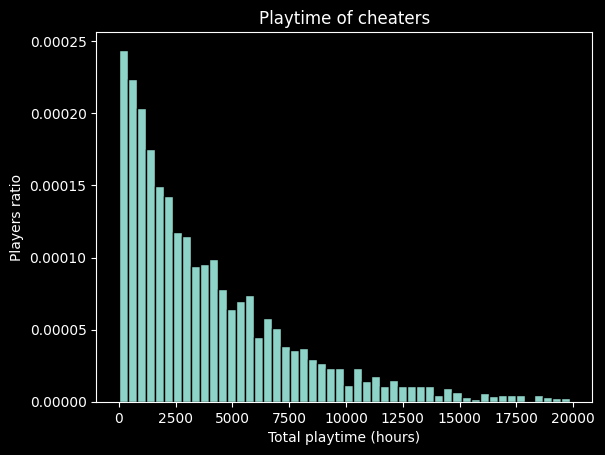

283


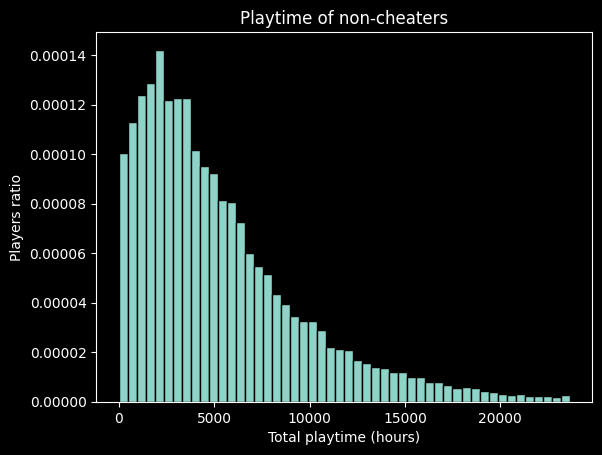

In [13]:
from statistics import stdev

from matplotlib.ticker import PercentFormatter


def extractTotalPlaytime(x: list[Entry] | None):
    if x is None:
        return 0

    sum = 0

    for g in x:
        sum += g.get("playtime_forever", 0)

    return sum


def extractTotalPlaytime2w(x: list[Entry] | None):
    if x is None:
        return 0

    sum = 0

    for g in x:
        sum += g.get("playtime_2weeks", 0)

    return sum


def extractTotalGames(x: list[Entry] | None):
    if x is None:
        return 0

    return len(x)

def plotPlaytime(data : DataFrame, title :str):
    playtime = data.loc[data["totalPlaytime"] > 0, "totalPlaytime"]

    ranges = np.quantile(playtime, [0.25, 0.5, 0.75])
    iqr = ranges[2] - ranges[0]
    lowerFence = ranges[0] - 3 * iqr
    upperFence = ranges[2] + 3 * iqr

    candidates = playtime[
        (playtime > lowerFence) & (playtime < upperFence)
    ]

    print(len(playtime) - len(candidates))

    plt.hist(candidates.apply(lambda x: x / 60 ), edgecolor='black', bins=50, density=True)
    plt.xlabel("Total playtime (hours)")
    plt.ylabel("Players ratio")
    plt.title(title)
    plt.show()


data["totalPlaytime"] = data["ownedGames"].apply(extractTotalPlaytime)
data["recentPlaytime"] = data["ownedGames"].apply(extractTotalPlaytime2w)
data["numGames"] = data["ownedGames"].apply(extractTotalGames)

cheaters = data.loc[
    (data["NumberOfVACBans"] + data["NumberOfGameBans"]) > 0,
    ["totalPlaytime", "recentPlaytime", "numGames"],
]
innocents = data.loc[
    (data["NumberOfVACBans"] + data["NumberOfGameBans"]) == 0,
    ["totalPlaytime", "recentPlaytime", "numGames"],
]

plotPlaytime(cheaters, "Playtime of cheaters")
plotPlaytime(innocents, "Playtime of non-cheaters")

## model cheating risk

### Some preprocessing

In [14]:
data["HasDefaultAvatar"] = data["avatar"] == "https://avatars.steamstatic.com/fef49e7fa7e1997310d705b2a6158ff8dc1cdfeb.jpg"
data.drop("avatar", inplace=True, axis=1)

In [62]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

data["NumFriends"] = data["augmentedFriends"].apply(lambda x: len(x))

countryLabels = LabelEncoder()
countryLabels.fit(data["loccountrycode"])
data["countryLabel"] = countryLabels.transform(data["loccountrycode"])

gameID = LabelEncoder()
gameID.fit(data["gameid"])
data["gameCode"] = gameID.transform(data["gameid"])

data["isCheater"] =  (data["NumberOfVACBans"] + data["NumberOfGameBans"]) > 0

def countCheatingFriends(friends : list[Entry]):
    num = 0 
    for friend in friends:
        if(friend not in data.index):
            continue

        if(data.loc[friend, "isCheater"]):
            num +=1

    return num
data["NumCheatingFriends"] = data["augmentedFriends"].apply(countCheatingFriends)

X = data.drop(
    [
        "LastBanTime",
        "MisdemenourCount",
        "EstimatedBanTimes",
        "NumberOfGameBans",
        "NumberOfVACBans",
        "DaysSinceLastBan",
        "augmentedFriends",
        "friendsList",
        "groups",
        "ownedGames",
        "recentlyPlayed",
        "gameid",
        "loccountrycode",
        "isCheater"
    ],
    axis=1,
)

X = X.fillna(-1)

Y = data["isCheater"]


### Helper function


In [126]:

from sklearn.metrics import auc, average_precision_score, f1_score, roc_auc_score

def trainAndTest(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = average_precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f'Accuracy: {accuracy}')
    print(f'F1 score: {f1}')
    print(f'Precision: {precision}')
    print(f'ROC AUC: {roc_auc}')

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

### Classifiers

#### Using a decision tree classifier

In [109]:
trainAndTest(tree.DecisionTreeClassifier(random_state=69), X_train, X_test, y_train, y_test)

Accuracy: 0.7653958944281525
F1 score: 0.2546583850931677
Precision: 0.17543314979950925
ROC AUC: 0.5600443859937531


#### Using Adaboost

In [142]:
from sklearn.ensemble import AdaBoostClassifier

trainAndTest(AdaBoostClassifier(random_state=69), X_train, X_test, y_train, y_test)

/home/derrick/Source/steam_cheater_network_analysis/.venv/lib64/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.8514173998044966
F1 score: 0.020257826887661142
Precision: 0.15622603103043645
ROC AUC: 0.5048842511453244


#### Using random forest

In [143]:
from sklearn.ensemble import RandomForestClassifier


trainAndTest(RandomForestClassifier(random_state=69), X_train, X_test, y_train, y_test)

Accuracy: 0.8374528697109342
F1 score: 0.1927877947295423
Precision: 0.1790007438689432
ROC AUC: 0.5458634575929681


#### Logistic regression

In [144]:
from sklearn.linear_model import LogisticRegression


trainAndTest(LogisticRegression("l2"), X_train, X_test, y_train, y_test)

Accuracy: 0.8503002373970115
F1 score: 0.0
Precision: 0.14969976260298842
ROC AUC: 0.5


In [145]:
from sklearn.svm import SVC


trainAndTest(SVC(), X_train, X_test, y_train, y_test)

Accuracy: 0.8503002373970115
F1 score: 0.0
Precision: 0.14969976260298842
ROC AUC: 0.5


### Regression

In [146]:

from sklearn.metrics import auc, average_precision_score, f1_score, roc_auc_score

def trainAndTestR(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    print(y_pred)
    return y_pred

In [147]:
Yp  = Y.apply(lambda x: 1.0 if x else 0.0).infer_objects(copy=False)
X_train, X_test, y_train, y_test = train_test_split(X, Yp, test_size=0.1)

#### Linear regression

In [148]:
from sklearn.linear_model import LinearRegression


p = trainAndTestR(LinearRegression(), X_train, X_test, y_train, y_test)

print(p)

[0.16557664 0.00024868 0.18608305 ... 0.12210005 0.24007561 0.17484169]
[0.16557664 0.00024868 0.18608305 ... 0.12210005 0.24007561 0.17484169]


###

#### Lasso

In [149]:
from sklearn.linear_model import Lasso


p = trainAndTestR(Lasso(), X_train, X_test, y_train, y_test)


[0.14639118 0.11773156 0.14582609 ... 0.14689593 0.147696   0.13635336]


### SVR

In [150]:
from sklearn.linear_model import Lasso
from sklearn.svm import LinearSVR


p = trainAndTest(LinearSVR(), X_train, X_test, y_train, y_test)


Accuracy: 0.8511381092026253
F1 score: 0.0
Precision: 0.14886189079737466
ROC AUC: 0.5


/home/derrick/Source/steam_cheater_network_analysis/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
